# Table of Contents

## 1) LDA
- determine number of topics

## 2) Visualization
- ### WordCloud
- ### PyLDAvis

In [1]:
import time, random, itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.externals import joblib

import pyLDAvis.sklearn

from wordcloud import WordCloud

archive_path1 = "./Archive/"
archive_path2 = "./Archive/Topic Modeling/"

In [2]:
df_vec = pd.read_csv(archive_path1+"vectorized_data.csv", index_col=0)

In [3]:
word_list = df_vec.columns
ids = df_vec.index

In [4]:
len(df_vec)

795548

## 1) LDA
- Number of Topics
- Likelihood, Perplexity

### Search for <code>n_topics</code>

In [5]:
df = df_vec[:1000].values
n_topic_min = 5
n_topic_max = 10

s1 = time.time()
scores = []
for i in range(n_topic_min, n_topic_max):
    print("n_topic = %s"%i)
    start = time.time()
    topics = i
    lda_model = LatentDirichletAllocation(n_components=topics,       # Number of topics
                                          max_iter=20,               # Max learning iterations
                                          learning_method='online',   
                                          random_state=100,          # Random state
                                          batch_size=128,            # n docs in each learning iter
                                          evaluate_every = -1,       # compute perplexity every n iters, default: Don't
#                                           n_jobs = -1,               # Use all available CPUs
                                         )
    lda_output = lda_model.fit_transform(df)
    print("fit model")

    end = time.time()
    print(round(end - start,2), "seconds")
    start = time.time()
    
    scores.append([i, lda_model.score(df), lda_model.perplexity(df)])
    print("model score")
        
    end = time.time()
    print(round(end - start, 2), "seconds")
    start = time.time()
e1 = time.time()
print("TOTAL:", round((e1 - s1)/60), "minutes")

n_topic = 5
fit model
1.49 seconds
model score
0.16 seconds
n_topic = 6
fit model
1.41 seconds
model score
0.17 seconds
n_topic = 7
fit model
1.36 seconds
model score
0.16 seconds
n_topic = 8
fit model
1.33 seconds
model score
0.18 seconds
n_topic = 9
fit model
1.48 seconds
model score
0.2 seconds
TOTAL: 0 minutes


### this could be multi-threaded

### Multiprocessing

In [6]:
from multiprocessing import Pool

def f(n_topics):
    lda_model = LatentDirichletAllocation(n_components=n_topics,       # Number of topics
                                          max_iter=20,               # Max learning iterations
                                          learning_method='online',   
                                          random_state=100,          # Random state
                                          batch_size=128,            # n docs in each learning iter
                                          evaluate_every = -1,       # compute perplexity every n iters, default: Don't
#                                           n_jobs = -1,               # Use all available CPUs
                                         )
    return lda_model, lda_model.fit_transform(df), lda_model.score(df), lda_model.perplexity(df)

In [7]:
df = df_vec[:1000].values
range_ = range(5,20)

#multi-threading
s1 = time.time()
pool = Pool(processes=12)
multi_models = []

for res in pool.map(f,range_):
    multi_models.append(res)
e1 = time.time()1) Data_Cleaning
print("multi:", e1-s1)

#sequential
s2 = time.time()
for i in range_:
    topics = i
    lda_model = LatentDirichletAllocation(n_components=topics,       # Number of topics
                                          max_iter=20,               # Max learning iterations
                                          learning_method='online',   
                                          random_state=100,          # Random state
                                          batch_size=128,            # n docs in each learning iter
                                          evaluate_every = -1,       # compute perplexity every n iters, default: Don't
#                                           n_jobs = -1,               # Use all available CPUs
                                         )
    lda_output = lda_model.fit_transform(df)
e2 = time.time()
print("single:", e2-s2)

multi: 7.931246280670166
single: 23.415866136550903


### much faster!

In [8]:
df_vec = pd.read_csv(archive_path1+"vectorized_data.csv", index_col=0)
df = df_vec[:].values
n_topic_min = 3
n_topic_max = 20
range_ = range(n_topic_min, n_topic_max)
n_processes = 12

# multi-threading
s = time.time()
pool = Pool(processes=n_processes)
multi_models = []
for res in pool.map(f,range_):
    multi_models.append(res)
e = time.time()
print(round((e-s)/60, 2), "minutes")

390.05 minutes


#### ipyparallel

In [9]:
# import ipyparallel as ipp
# import numpy
# rc = ipp.Client()
# dview = rc[:]
# dview.block=True #sync between engines and kernel

# dview.execute("import pandas as pd")
# dview.execute("from sklearn.decomposition import LatentDirichletAllocation")
# dview["df"] = df

In [10]:
# s = time.time()
# parallel_results = dview.map(f, numpy.arange(n_topic_min, n_topic_max))
# e = time.time()
# print(round((e-s)/60, 2), "minutes")

#### Same Result

In [11]:
# len(multi_models) == len(parallel_results)

In [12]:
# multi_models[0][1]

In [13]:
# parallel_results[0][1]

### Archive

In [14]:
# scores = []
# for i, model in enumerate(multi_models):
#     lda_model, lda_output, score, perplexity = model
#     scores.append([i+n_topic_min, score, perplexity])
#     if i < 10:
#         count = "0"+str(i)
#     else:
#         count = str(i)
#     joblib.dump(lda_model, archive_path2+'lda_model_%s.sav'%count)
#     np.save(archive_path2+"lda_output_%s.npy"%count, lda_output)
#     np.save(archive_path2+"lda_components_%s.npy"%count, lda_model.components_)
# pd.DataFrame(scores).to_csv(archive_path2+"scores.csv")

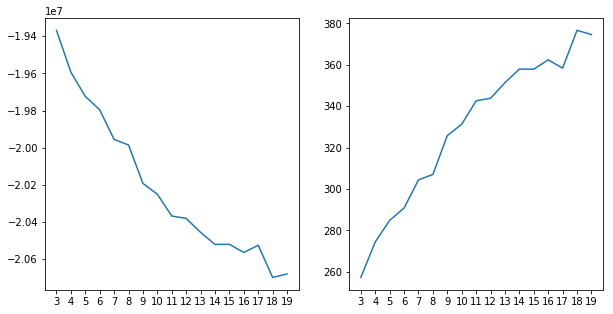

In [15]:
scores = pd.read_csv(archive_path2+"scores.csv", index_col=0).values
scores = np.array(scores)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xticks(scores[:,0].astype(int))
plt.plot(scores[:,0].astype(int), scores[:, 1])
plt.subplot(1,2,2)
plt.xticks(scores[:,0].astype(int))
plt.plot(scores[:,0].astype(int), scores[:, 2])

### Load Model

In [16]:
topics = 9
count = topics - 3
count = "0"+str(count)
lda_output = np.load(archive_path2+"lda_output_%s.npy"%count)
lda_components = np.load(archive_path2+"lda_components_%s.npy"%count)

In [17]:
pd.DataFrame(lda_output).sum() / pd.DataFrame(lda_output).sum().sum() * 100

0    12.527014
1     8.938991
2    14.729369
3     8.138210
4     9.589469
5    12.495551
6    11.249885
7    11.968503
8    10.363009
dtype: float64

In [18]:
order = pd.DataFrame(lda_output).sum().sort_values(ascending=False).index

In [19]:
# column names
topic_names = ["Topic" + str(i+1) for i in range(topics)]
# index names
tweet_keys = ids

df_document_topic = pd.DataFrame(data = np.round(lda_output, 2), index=tweet_keys)
df_document_topic = df_document_topic[order]
df_document_topic.columns = topic_names

dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['Dominant'] = dominant_topic+1

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

In [20]:
# show topic and tweets
pd.DataFrame(df_document_topic.iloc[:, -1].value_counts().reset_index().values, columns=["topic", "n_tweets"])

topic  n_tweets
0      1    237182
1      2    138509
2      3    108271
3      4     83559
4      5     67882
5      6     59569
6      7     44125
7      8     31816
8      9     24635

In [21]:
# 10 topics and their consisting words
# df_topic_words = pd.DataFrame(lda_components, index = topic_names, columns = word_list)
df_topic_words = pd.DataFrame(lda_components).loc[order]
df_topic_words.index = topic_names
df_topic_words.columns = word_list

In [22]:
df_topic_words

aan     aangifte    afgelopen   afschaffen    alexander  \
Topic1      0.111139     0.111134     0.111137  3811.746993     0.111117   
Topic2      0.111140     0.111156     0.111141     0.111124     0.111119   
Topic3      0.111135  3946.439472     0.111146     0.111123     0.111121   
Topic4      0.111142     0.111140     0.111134     0.111130     0.111120   
Topic5      0.111138     0.111142     0.111150     0.111124     0.111120   
Topic6      0.111140     0.111195     0.111128     0.111151     0.111120   
Topic7      0.111149     0.111149  3930.835713     0.111129     0.111127   
Topic8  11058.335053     0.111184     0.111123     0.111140  5420.178942   
Topic9      0.111132     0.111137     0.111137     0.111159     0.111121   

              alleen       altijd          amp     amsterdam  amsterdamse  \
Topic1      0.111133     0.111150     0.111154      0.111135     0.111132   
Topic2      0.111144     0.111154  4683.919671      0.111124     0.111131   
Topic3      0.111130     0.111146     0.111132      0.111133  2503.305770   
Topic4      0.111156     0.111156     0.111146      0.111132     0.111157   
Topic5      0.111138  4686.383664     0.111132  24728.677594     0.111166   
Topic6      0.111149     0.111142     0.111153      0.111133     0.111146   
Topic7      0.111143     0.111147     0.111144      0.111133     0.111150   
Topic8      0.111135     0.111143     0.111136      0.111132     0.111133   
Topic9  12933.301800     0.111150     0.111143      0.111128     0.111128   

            ...              ziet      zijlstra          zijn          zit  \
Topic1      ...          0.111151      0.111135      0.111152     0.111153   
Topic2      ...          0.111216      0.111120      0.111148     0.111162   
Topic3      ...          0.111137      0.111129  41594.400385     0.111145   
Topic4      ...       4216.500042      0.111129      0.111164     0.111150   
Topic5      ...          0.111137      0.111135      0.111150  6610.015888   
Topic6      ...          0.111169      0.111139      0.111144     0.111155   
Topic7      ...          0.111187  32557.140575      0.111144     0.111145   
Topic8      ...          0.111149      0.111128      0.111151     0.111150   
Topic9      ...          0.111151      0.111176      0.111154     0.111139   

             zitten   zoetermeer      zojuist         zorg       zorgen  \
Topic1     0.111139  2996.869210     0.111133     0.111139     0.111150   
Topic2     0.111148     0.111128     0.111128     0.111136     0.111133   
Topic3     0.111134     0.111273     0.111130     0.111138     0.111142   
Topic4     0.111155     0.111172     0.111130  5061.594201  3573.816143   
Topic5     0.111140     0.111120     0.111134     0.111134     0.111138   
Topic6     0.111140     0.111178     0.111153     0.111127     0.111129   
Topic7  3405.622826     0.111194     0.111140     0.111137     0.111141   
Topic8     0.111135     0.111114  1998.001249     0.111126     0.111168   
Topic9     0.111143     0.111121     0.111164     0.111139     0.111142   

                 zou  
Topic1      0.111137  
Topic2      0.111135  
Topic3      0.111147  
Topic4      0.111141  
Topic5      0.111135  
Topic6      0.111144  
Topic7      0.111139  
Topic8      0.111139  
Topic9  13616.809225  

[9 rows x 403 columns]

In [23]:
df_keywords = pd.DataFrame(columns=np.arange(15))
for row in df_topic_words.index:
    df_keywords.loc[row] = df_topic_words.loc[row].sort_values(ascending=False).head(15).index.values
df_keywords

0          1           2          3       4          5   \
Topic1       vvd       denk        stem       weer   wordt  nederland   
Topic2       pvv       pvda     wilders      geert    hier       heel   
Topic3       cda       zijn  groenlinks    vandaag     was  rotterdam   
Topic4       ook       gaat         dan     mensen  worden       waar   
Topic5       fvd  amsterdam        moet        kan     wel        hoe   
Topic6    baudet    thierry      hebben  ollongren     dus      kajsa   
Topic7  zijlstra      halbe         sgp       doen   debat       komt   
Topic8  pechtold        nog      partij       toch    eens        aan   
Topic9     rutte      heeft    minister    stemmen    gaan       mark   

                    6             7          8          9          10  \
Topic1      referendum  verkiezingen       echt       even     willen   
Topic2          moeten          meer  lodewijka  stemzeweg     nieuwe   
Topic3    christenunie          jaar      forum      tponl   kamerlid   
Topic4            goed      politiek      lijst       voor       zegt   
Topic5          waarom        gewoon   grootste        heb      islam   
Topic6        togetter     eqexyokei        ben        uit        van   
Topic7            daar           mee      staat      kamer       kaag   
Topic8  joostniemoller         maakt  ananninga      vindt  penthouse   
Topic9           maart           zou     alleen        mag        net   

                 11         12               13            14  
Topic1     partijen       weet           steeds        daarom  
Topic2          zie       nida        telegraaf          laat  
Topic3          zal      samen           blijft           jan  
Topic4          wel        ers           zetels         motie  
Topic5         doet      grote         gemeente          land  
Topic6      minpres        weg  referendumdebat           man  
Topic7        maken       tijd              had  lijsttrekker  
Topic8  ddstandaard  alexander            geeft           lid  
Topic9    politieke     zeggen           poetin         zaken

## 2) Visualization

### WordCloud

In [24]:
df_topic_words

aan     aangifte    afgelopen   afschaffen    alexander  \
Topic1      0.111139     0.111134     0.111137  3811.746993     0.111117   
Topic2      0.111140     0.111156     0.111141     0.111124     0.111119   
Topic3      0.111135  3946.439472     0.111146     0.111123     0.111121   
Topic4      0.111142     0.111140     0.111134     0.111130     0.111120   
Topic5      0.111138     0.111142     0.111150     0.111124     0.111120   
Topic6      0.111140     0.111195     0.111128     0.111151     0.111120   
Topic7      0.111149     0.111149  3930.835713     0.111129     0.111127   
Topic8  11058.335053     0.111184     0.111123     0.111140  5420.178942   
Topic9      0.111132     0.111137     0.111137     0.111159     0.111121   

              alleen       altijd          amp     amsterdam  amsterdamse  \
Topic1      0.111133     0.111150     0.111154      0.111135     0.111132   
Topic2      0.111144     0.111154  4683.919671      0.111124     0.111131   
Topic3      0.111130     0.111146     0.111132      0.111133  2503.305770   
Topic4      0.111156     0.111156     0.111146      0.111132     0.111157   
Topic5      0.111138  4686.383664     0.111132  24728.677594     0.111166   
Topic6      0.111149     0.111142     0.111153      0.111133     0.111146   
Topic7      0.111143     0.111147     0.111144      0.111133     0.111150   
Topic8      0.111135     0.111143     0.111136      0.111132     0.111133   
Topic9  12933.301800     0.111150     0.111143      0.111128     0.111128   

            ...              ziet      zijlstra          zijn          zit  \
Topic1      ...          0.111151      0.111135      0.111152     0.111153   
Topic2      ...          0.111216      0.111120      0.111148     0.111162   
Topic3      ...          0.111137      0.111129  41594.400385     0.111145   
Topic4      ...       4216.500042      0.111129      0.111164     0.111150   
Topic5      ...          0.111137      0.111135      0.111150  6610.015888   
Topic6      ...          0.111169      0.111139      0.111144     0.111155   
Topic7      ...          0.111187  32557.140575      0.111144     0.111145   
Topic8      ...          0.111149      0.111128      0.111151     0.111150   
Topic9      ...          0.111151      0.111176      0.111154     0.111139   

             zitten   zoetermeer      zojuist         zorg       zorgen  \
Topic1     0.111139  2996.869210     0.111133     0.111139     0.111150   
Topic2     0.111148     0.111128     0.111128     0.111136     0.111133   
Topic3     0.111134     0.111273     0.111130     0.111138     0.111142   
Topic4     0.111155     0.111172     0.111130  5061.594201  3573.816143   
Topic5     0.111140     0.111120     0.111134     0.111134     0.111138   
Topic6     0.111140     0.111178     0.111153     0.111127     0.111129   
Topic7  3405.622826     0.111194     0.111140     0.111137     0.111141   
Topic8     0.111135     0.111114  1998.001249     0.111126     0.111168   
Topic9     0.111143     0.111121     0.111164     0.111139     0.111142   

                 zou  
Topic1      0.111137  
Topic2      0.111135  
Topic3      0.111147  
Topic4      0.111141  
Topic5      0.111135  
Topic6      0.111144  
Topic7      0.111139  
Topic8      0.111139  
Topic9  13616.809225  

[9 rows x 403 columns]

In [25]:
df_wordcloud = (df_topic_words.apply(lambda x: x/x.sum(), axis=1)*50).astype(int)
df_wordcloud

aan  aangifte  afgelopen  afschaffen  alexander  alleen  altijd  amp  \
Topic1    0         0          0           0          0       0       0    0   
Topic2    0         0          0           0          0       0       0    0   
Topic3    0         0          0           0          0       0       0    0   
Topic4    0         0          0           0          0       0       0    0   
Topic5    0         0          0           0          0       0       0    0   
Topic6    0         0          0           0          0       0       0    0   
Topic7    0         0          0           0          0       0       0    0   
Topic8    2         0          0           0          0       0       0    0   
Topic9    0         0          0           0          0       2       0    0   

        amsterdam  amsterdamse ...   ziet  zijlstra  zijn  zit  zitten  \
Topic1          0            0 ...      0         0     0    0       0   
Topic2          0            0 ...      0         0     0    0       0   
Topic3          0            0 ...      0         0     5    0       0   
Topic4          0            0 ...      0         0     0    0       0   
Topic5          3            0 ...      0         0     0    0       0   
Topic6          0            0 ...      0         0     0    0       0   
Topic7          0            0 ...      0         4     0    0       0   
Topic8          0            0 ...      0         0     0    0       0   
Topic9          0            0 ...      0         0     0    0       0   

        zoetermeer  zojuist  zorg  zorgen  zou  
Topic1           0        0     0       0    0  
Topic2           0        0     0       0    0  
Topic3           0        0     0       0    0  
Topic4           0        0     0       0    0  
Topic5           0        0     0       0    0  
Topic6           0        0     0       0    0  
Topic7           0        0     0       0    0  
Topic8           0        0     0       0    0  
Topic9           0        0     0       0    2  

[9 rows x 403 columns]

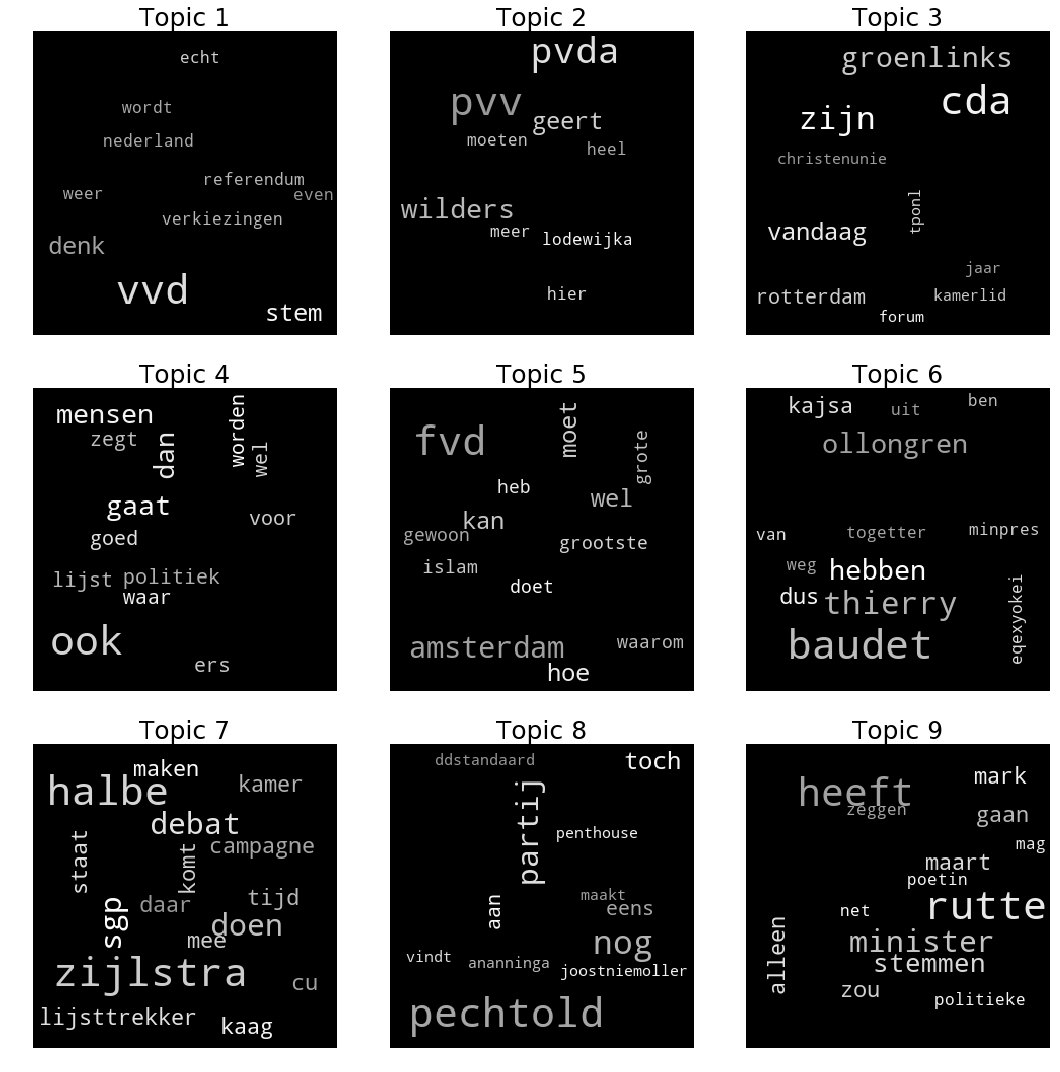

In [26]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

def plot_wordcloud(df_wordcloud, nrows=3, ncols=3):
    fig, axes = plt.subplots(figsize = (5*ncols,5*nrows), ncols=ncols, nrows=nrows)
    if (nrows == 1) | (ncols == 1):
        locs=list(range(max(nrows,ncols)))
    else:
        locs=list(itertools.product(range(nrows), range(ncols)))

    for i, r in enumerate(df_wordcloud.index):
        row = df_wordcloud.loc[r]
        row = row.sort_values(ascending=False)
        row = np.repeat(row.index, row.values).tolist()
        random.shuffle(row)
        random.shuffle(row)
        random.shuffle(row)
        random.shuffle(row)
        random.shuffle(row)
        row = " ".join(row)
        all_text = row
        wordcloud = WordCloud(width=300, height=300,
                              relative_scaling=0.5,max_font_size=40,color_func=grey_color_func,
                             ).generate(all_text)
        loc = locs[i]
        ax = axes[loc]
        ax.imshow(wordcloud)
        ax.axis("off")
        ax.set_title("Topic %s"%(i+1), size=25)    
    fig.tight_layout()
plot_wordcloud(df_wordcloud, ncols=3, nrows=3)

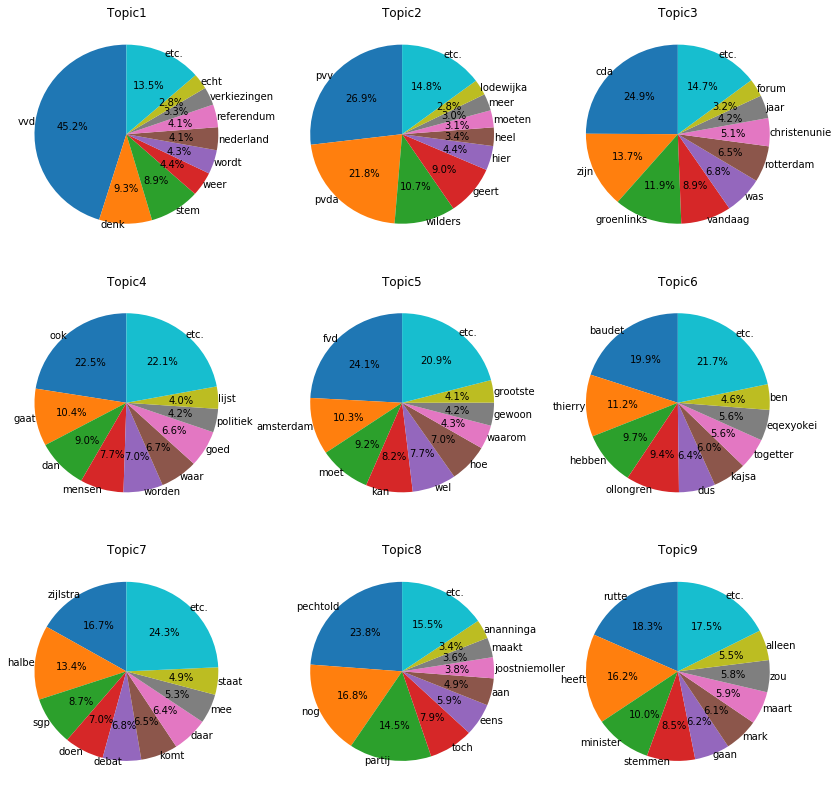

In [27]:
p = 40
plt.figure(figsize=(14,14))
for i,row in enumerate(df_topic_words.iterrows()):
    row = row[1]
    row = row.sort_values(ascending=False).head(15)
    show = row.values > np.percentile(row.values, p)
    non_show = row.values <= np.percentile(row.values, p)

    new_row_val = row.values[show].tolist()
    new_row_val.append(row.values[non_show].sum())

    new_row_index = row.index[show].tolist()
    new_row_index.append("etc.")
    
    plt.subplot(3,3,i+1)
    plt.pie(new_row_val, labels=new_row_index, startangle=90, labeldistance=1.0,
            autopct='%.1f%%')
    plt.title(row.name)

### PyLDAvis

In [29]:
filename = archive_path2+'vectorizer.sav'
vectorizer = joblib.load(filename)

filename = archive_path2+'data_vectorized.sav'
data_vectorized = joblib.load(filename)

filename = archive_path2+'lda_model_%s.sav'%count
lda_model = joblib.load(filename)

pyLDAvis.enable_notebook()

panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/home/yuvenious/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      112.597542 -246.554001       1        1  14.577518
7     -208.914154  -85.808403       2        1  12.568131
0      -61.806976   47.002968       3        1  12.530954
5     -232.440323  113.502678       4        1  11.766017
6      125.345261  112.565063       5        1  11.683310
8      -98.786865 -240.308853       6        1  10.266929
4       19.935333  -90.220551       7        1   9.513553
1      -38.251907  228.658035       8        1   8.879152
3      208.544373  -57.998974       9        1   8.214436, topic_info=     Category           Freq           Term          Total  loglift  logprob
term                                                                        
352   Default  170630.000000            vvd  170630.000000  30.0000  30.0000
269   Default   88529.000000            pvv   88529.000000  29.0000  29.0000
37    Default   76027.000000            cda   76027.000000  28.0000  28.0000
267   Default   71754.000000           pvda   71754.000000  27.0000  27.0000
253   Default   60841.000000       pechtold   60841.000000  26.0000  26.0000
85    Default   60618.000000            fvd   60618.000000  25.0000  25.0000
285   Default   46839.000000          rutte   46839.000000  24.0000  24.0000
16    Default   51136.000000         baudet   51136.000000  23.0000  23.0000
240   Default   53582.000000            ook   53582.000000  22.0000  22.0000
231   Default   43067.000000            nog   43067.000000  21.0000  21.0000
121   Default   41578.000000          heeft   41578.000000  20.0000  20.0000
249   Default   37060.000000         partij   37060.000000  19.0000  19.0000
395   Default   41881.000000           zijn   41881.000000  18.0000  18.0000
108   Default   36444.000000     groenlinks   36444.000000  17.0000  17.0000
394   Default   33138.000000       zijlstra   33138.000000  16.0000  16.0000
370   Default   35322.000000        wilders   35322.000000  15.0000  15.0000
50    Default   35103.000000           denk   35103.000000  14.0000  14.0000
314   Default   28766.000000        thierry   28766.000000  13.0000  13.0000
302   Default   33530.000000           stem   33530.000000  12.0000  12.0000
205   Default   25734.000000       minister   25734.000000  11.0000  11.0000
115   Default   26564.000000          halbe   26564.000000  10.0000  10.0000
91    Default   29790.000000          geert   29790.000000   9.0000   9.0000
333   Default   27047.000000        vandaag   27047.000000   8.0000   8.0000
119   Default   24877.000000         hebben   24877.000000   7.0000   7.0000
8     Default   25827.000000      amsterdam   25827.000000   6.0000   6.0000
237   Default   24110.000000      ollongren   24110.000000   5.0000   5.0000
304   Default   21722.000000        stemmen   21722.000000   4.0000   4.0000
87    Default   24695.000000           gaat   24695.000000   3.0000   3.0000
208   Default   23073.000000           moet   23073.000000   2.0000   2.0000
316   Default   20086.000000           toch   20086.000000   1.0000   1.0000
...       ...            ...            ...            ...      ...      ...
5      Topic9   14048.206065         alleen   14049.118507   2.4992  -3.0158
196    Topic9    9659.858326            mag    9660.770726   2.4992  -3.3903
224    Topic9    9144.714993            net    9145.627420   2.4992  -3.4451
262    Topic9    7789.683920      politieke    7790.596370   2.4992  -3.6055
384    Topic9    6969.195777         zeggen    6970.108174   2.4991  -3.7168
258    Topic9    5908.245280         poetin    5909.157750   2.4991  -3.8820
380    Topic9    5339.365502          zaken    5340.277809   2.4991  -3.9832
341    Topic9    4535.615565         vinden    4536.527968   2.4991  -4.1464
279    Topic9    4343.318361  referendumwet    4344.230886   2.4991  -4.1897
59     Topic9    4187.143474      duidelijk    4188.055877   2.4991  -4.2263
32     T

### Check robustness with different random_state (<code>n_topics = 9</code>)

In [29]:
topics = 9
n_processes = 12
seed = [(i+1)*100 for i in range(n_processes)]

In [30]:
topic_names = ["Topic" + str(i+1) for i in range(topics)]
df = df_vec[:].values

def f(seed, df=df):
    lda_model = LatentDirichletAllocation(n_components=9,       # Number of topics
                                          max_iter=20,               # Max learning iterations
                                          learning_method='online',   
                                          random_state=seed,          # Random state
                                          batch_size=128,            # n docs in each learning iter
                                          evaluate_every = -1,       # compute perplexity every n iters, default: Don't
#                                           n_jobs = -1,               # Use all available CPUs
                                         )
    return lda_model, lda_model.fit_transform(df), lda_model.score(df), lda_model.perplexity(df)
s = time.time()
pool = Pool(processes=n_processes)
multi_models = []
for res in pool.map(f, seed):
    multi_models.append(res)
e = time.time()
print(round((e-s)/60, 2), "minutes")

45.42 minutes


### Archive

In [31]:
for i, s in enumerate(seed):
    model = multi_models[i]
    lda_model = model[0]
    lda_components = lda_model.components_
    lda_output = model[1]
    joblib.dump(lda_model, archive_path2+'lda_model_chkrobust_%s.sav'%s)
    np.save(archive_path2+"lda_output_chkrobust_%s.npy"%s, lda_output)
    np.save(archive_path2+"lda_components_chkrobust_%s.npy"%s, lda_model.components_)

### Load and Plot

/home/yuvenious/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


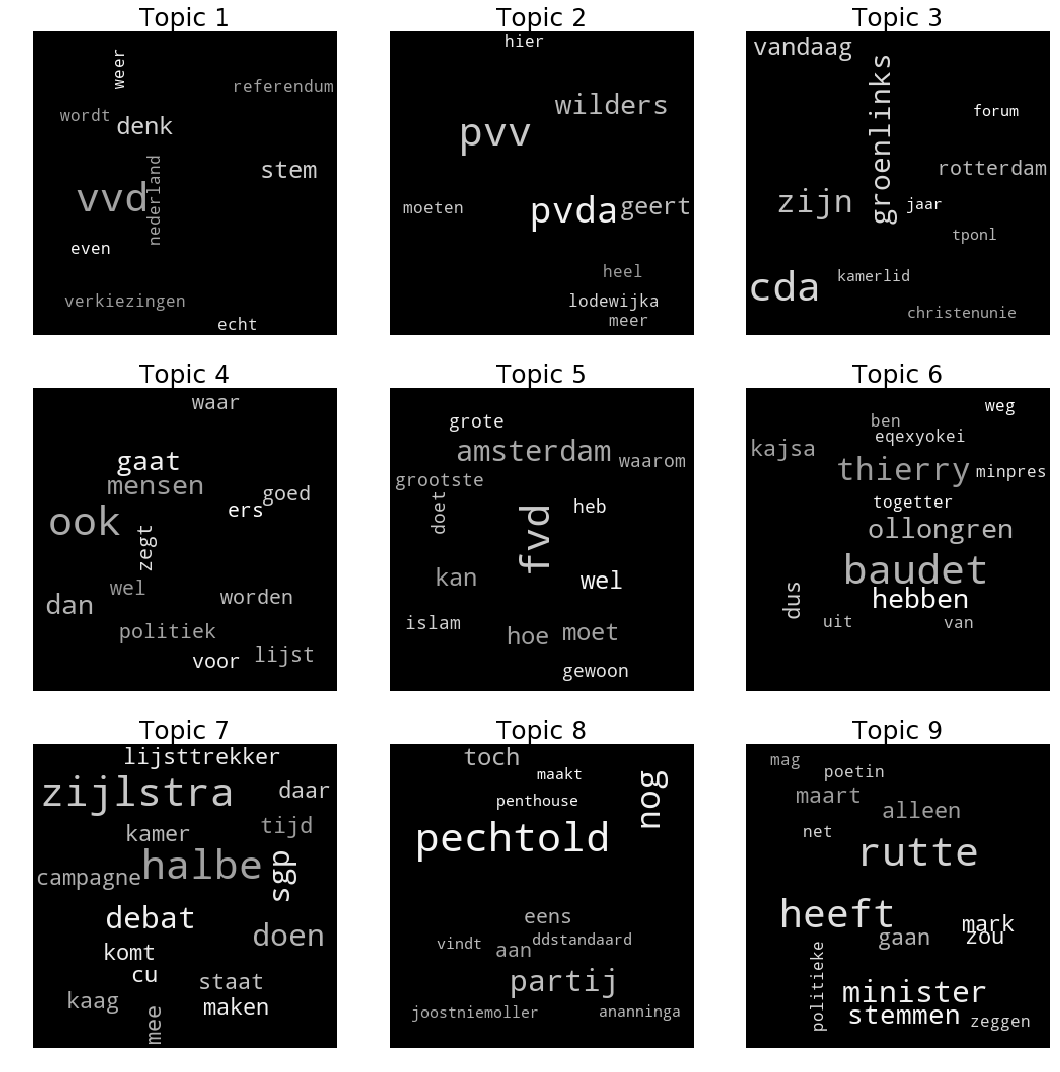

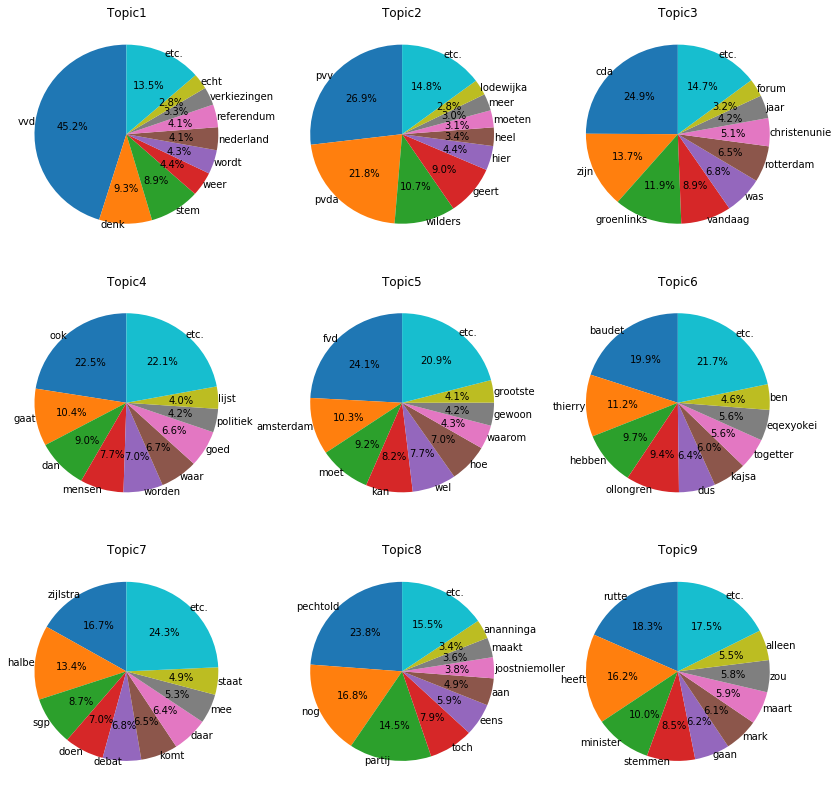

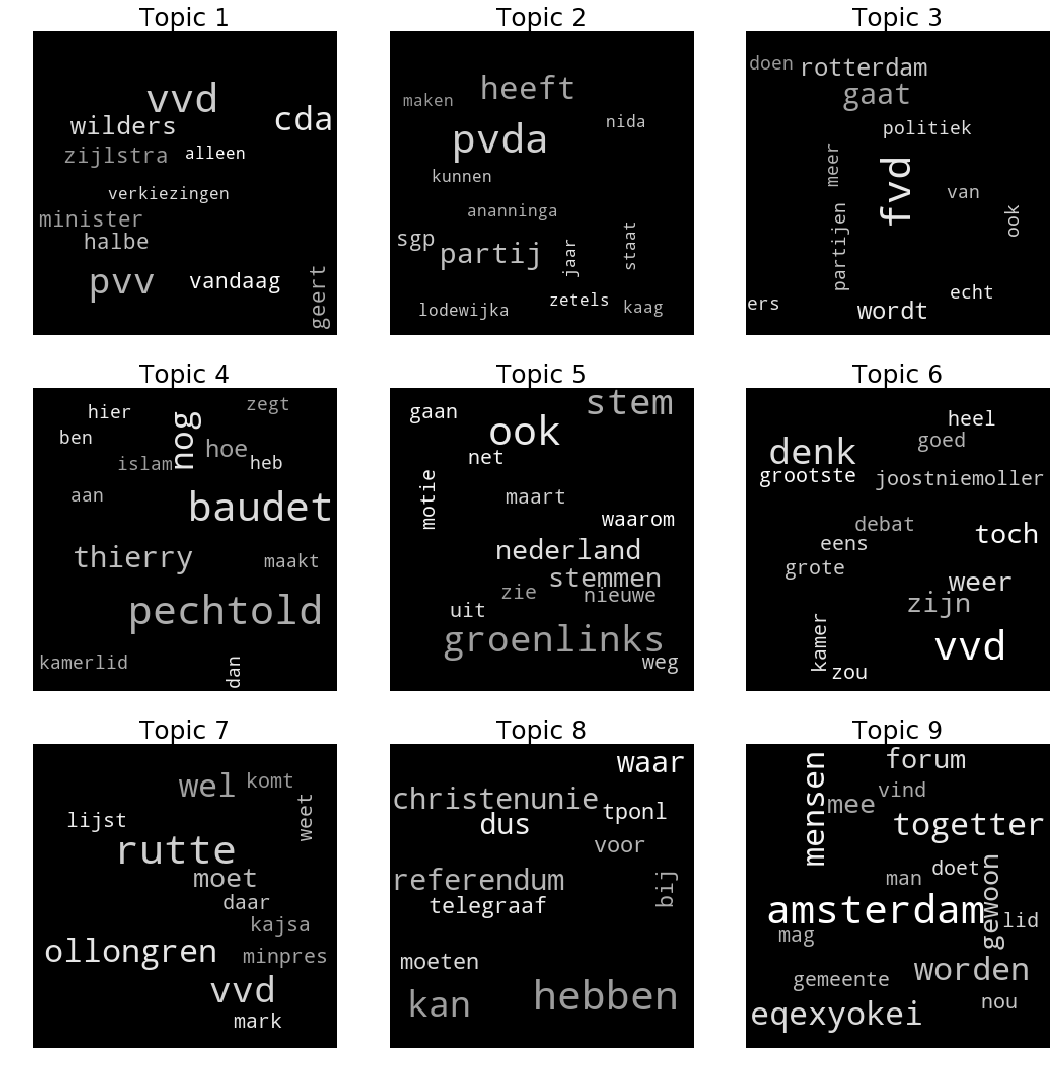

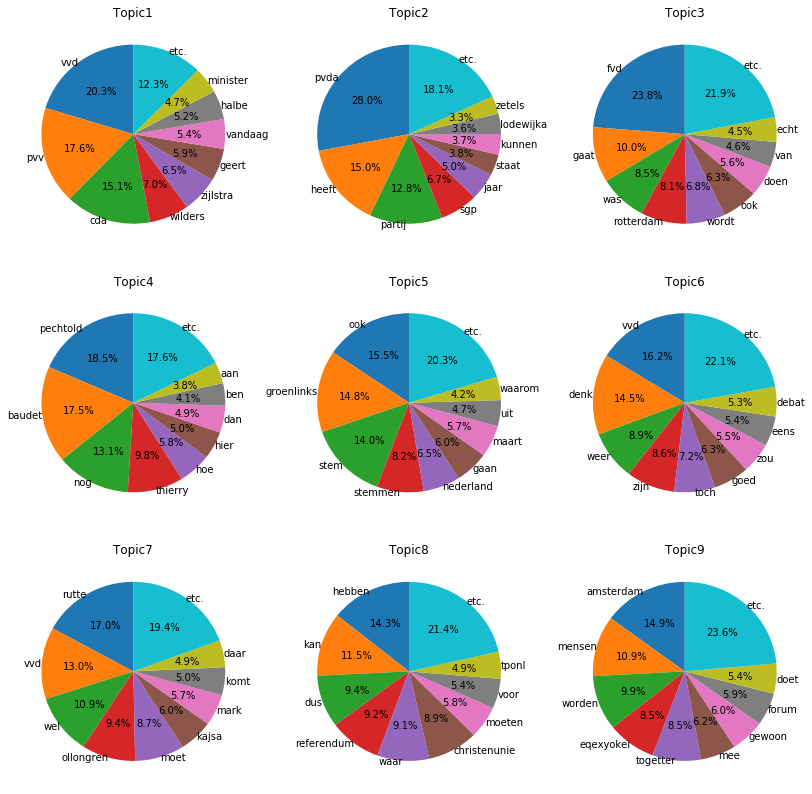

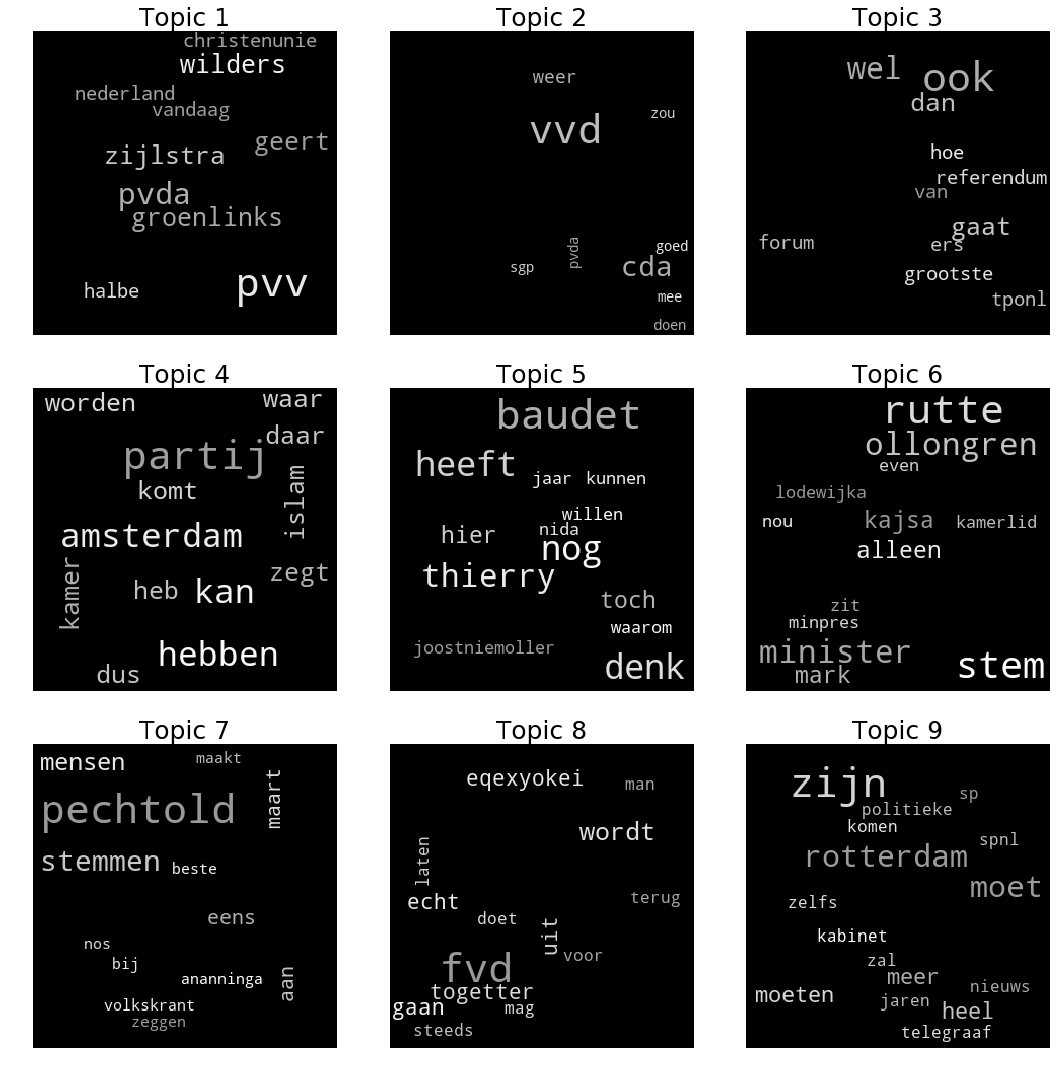

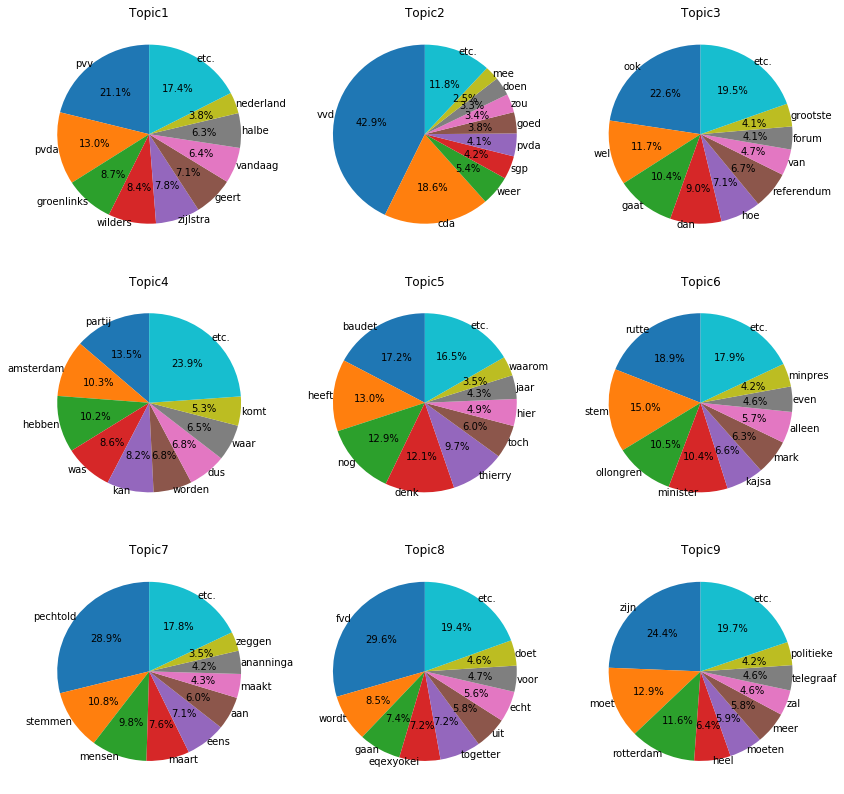

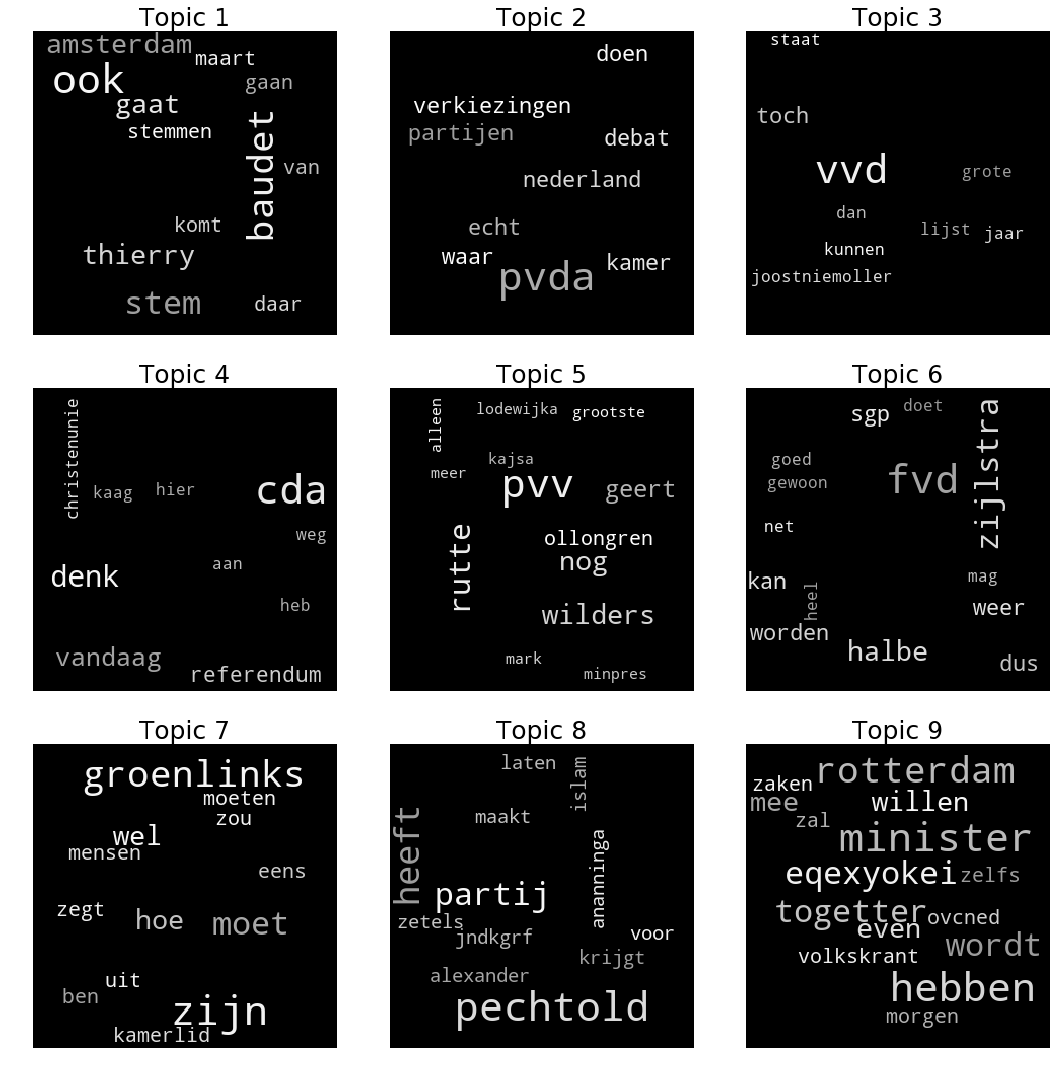

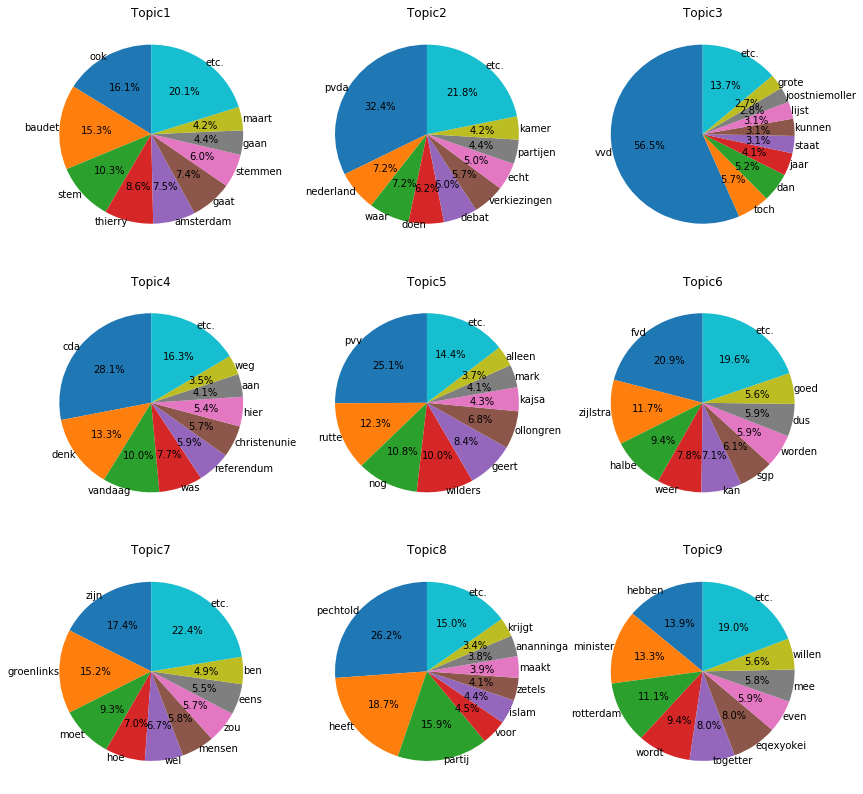

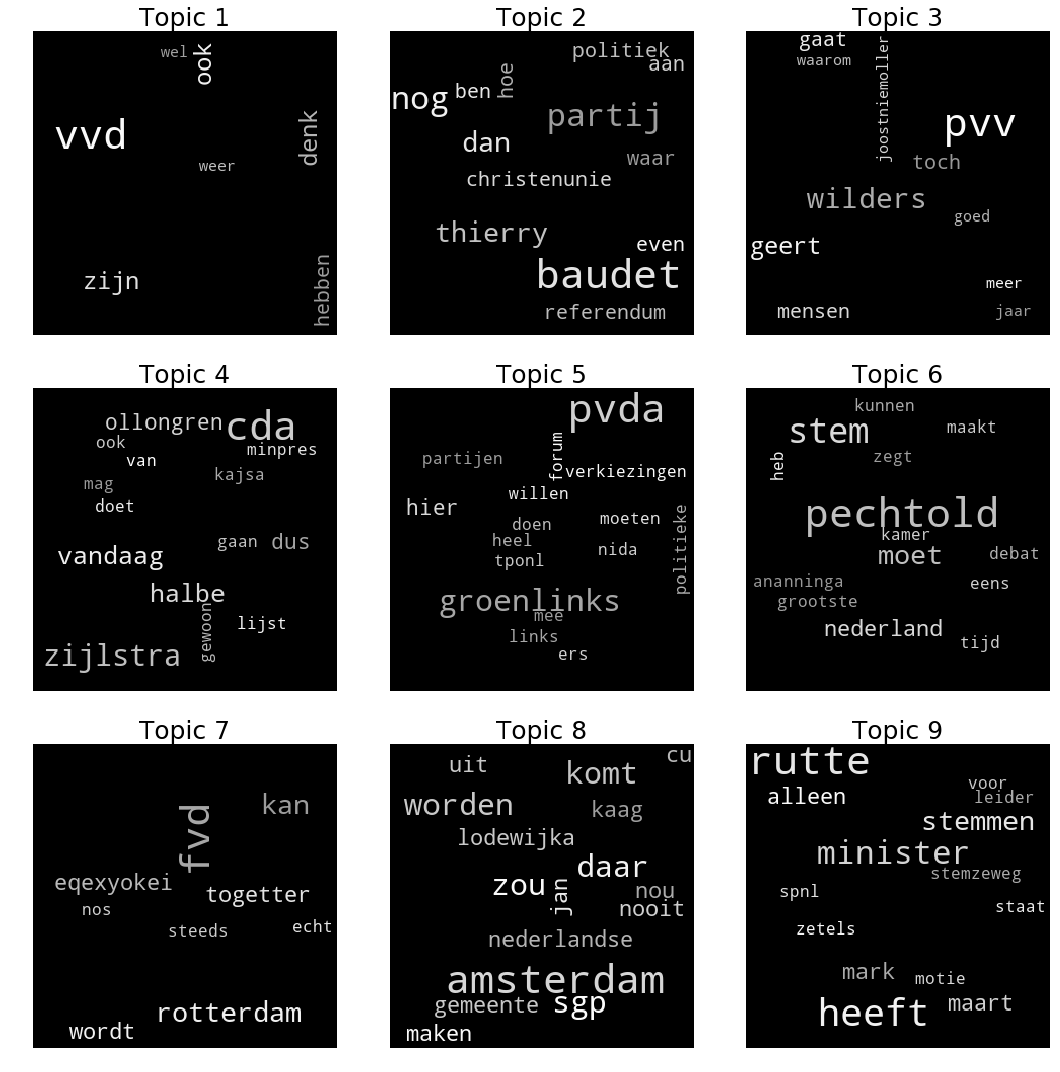

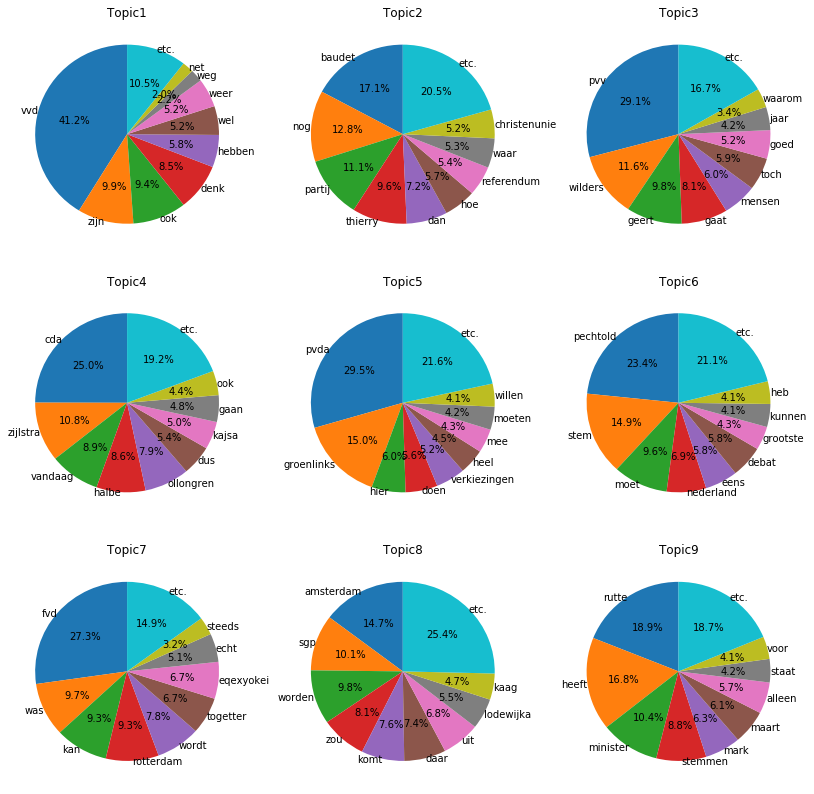

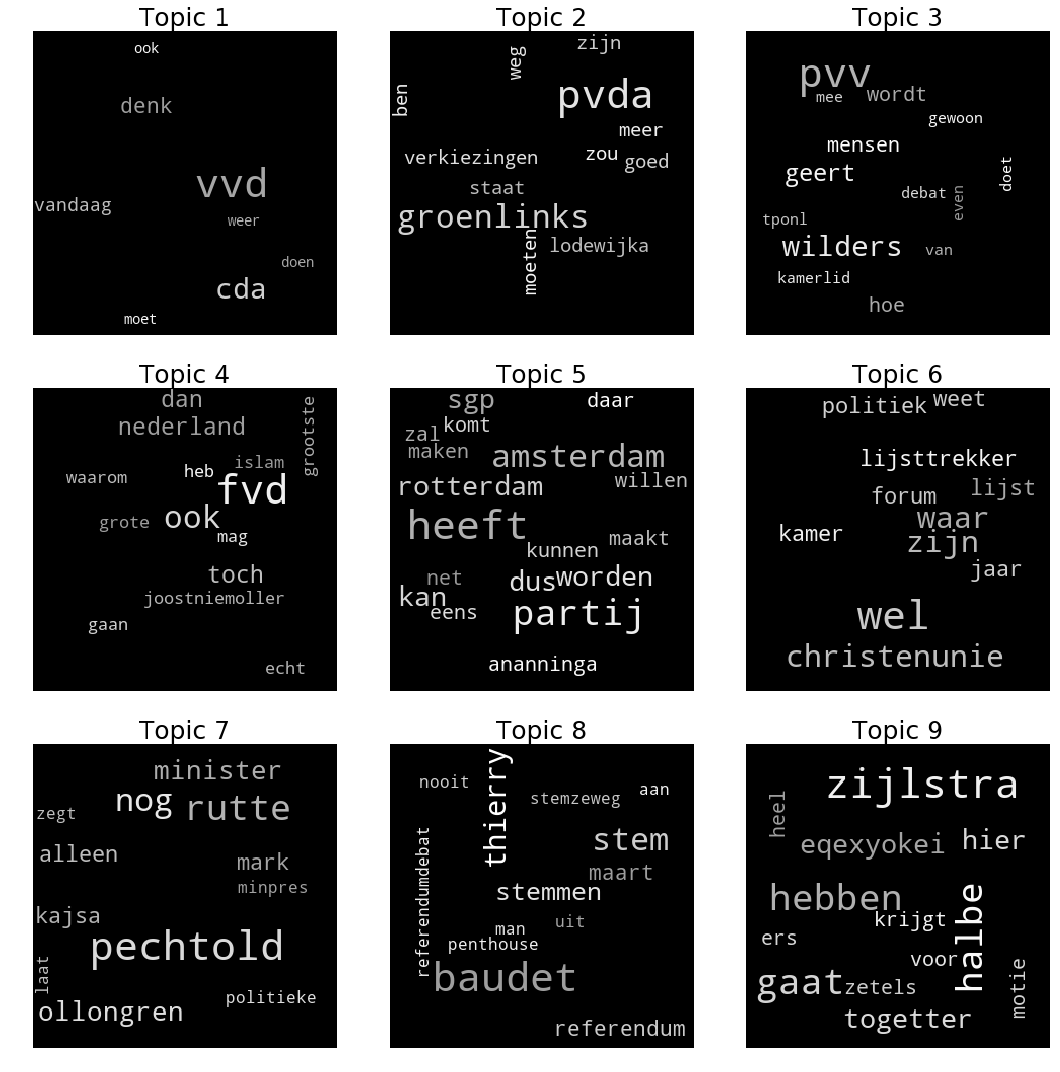

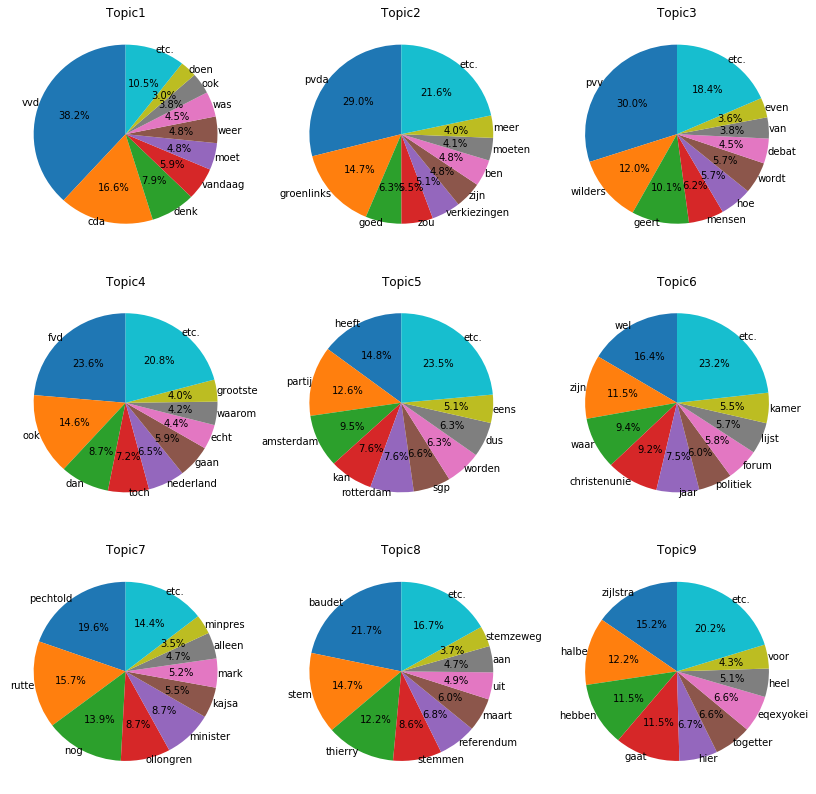

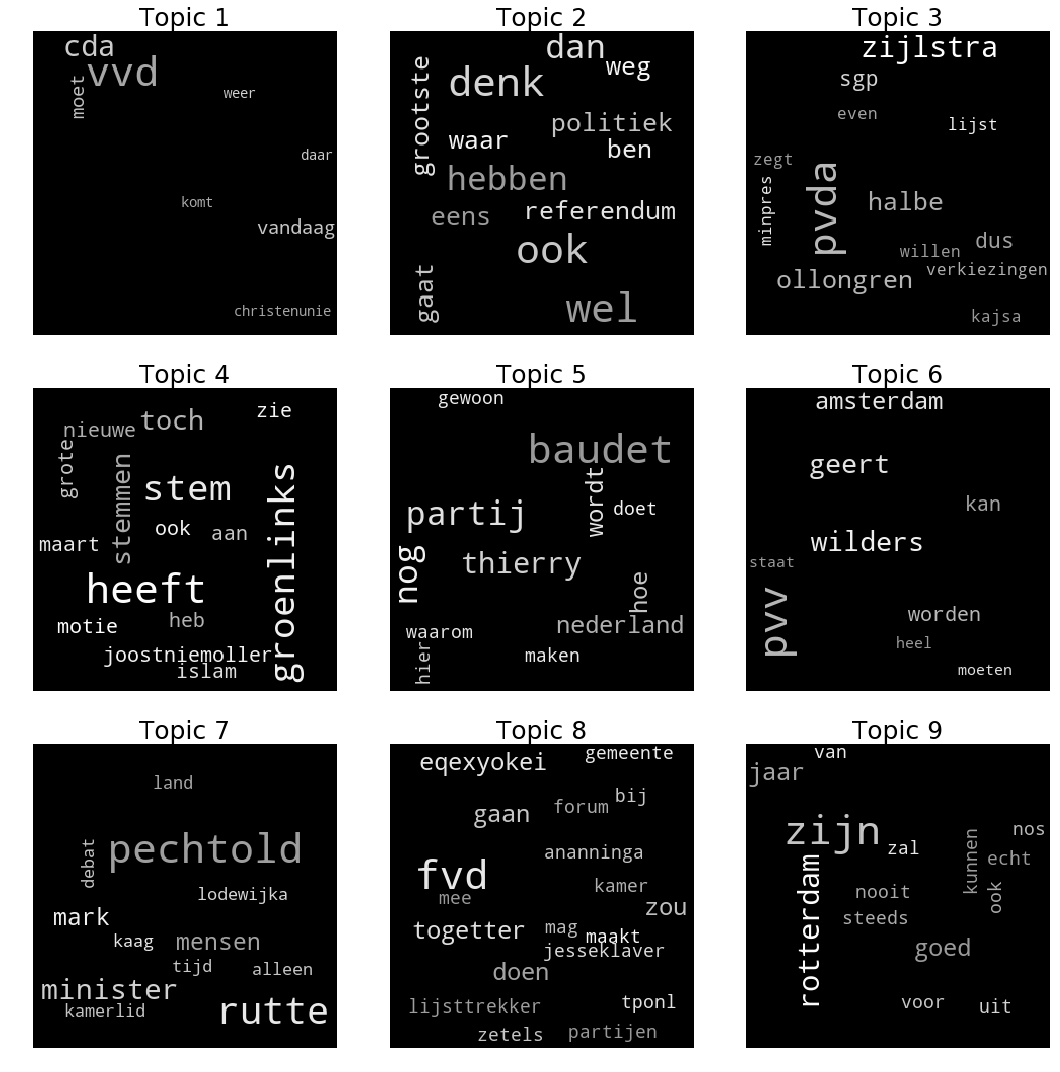

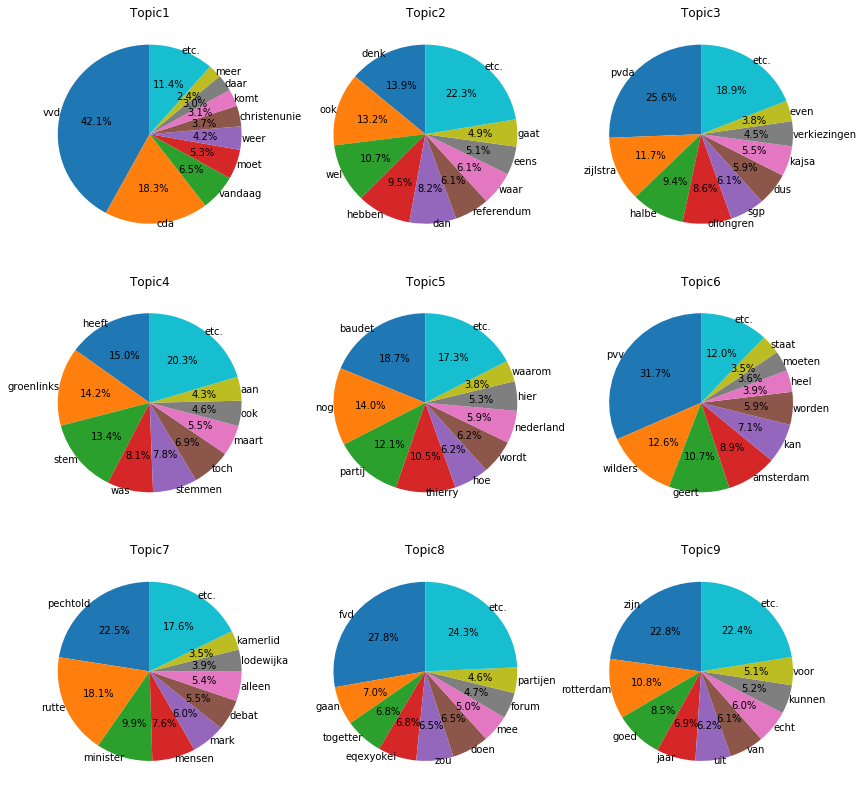

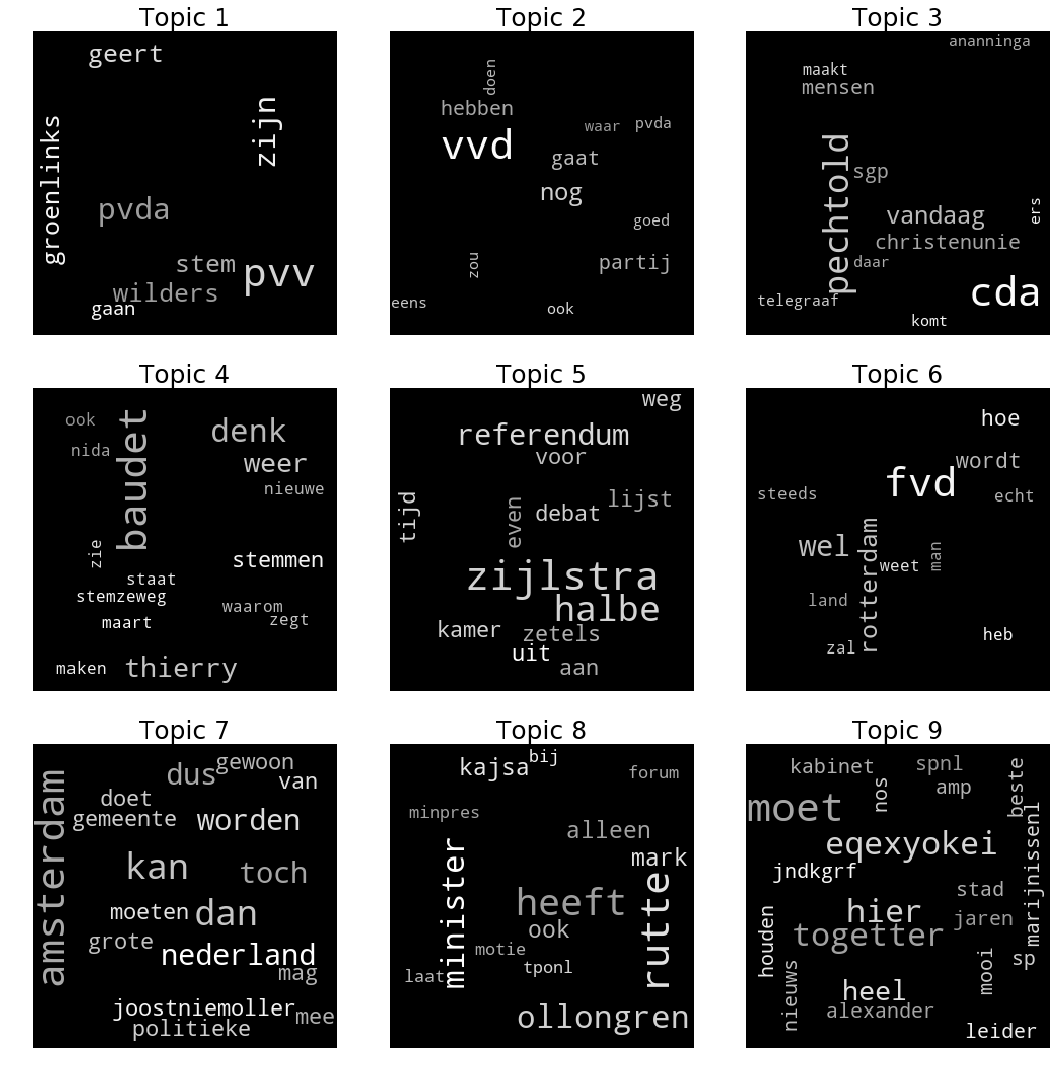

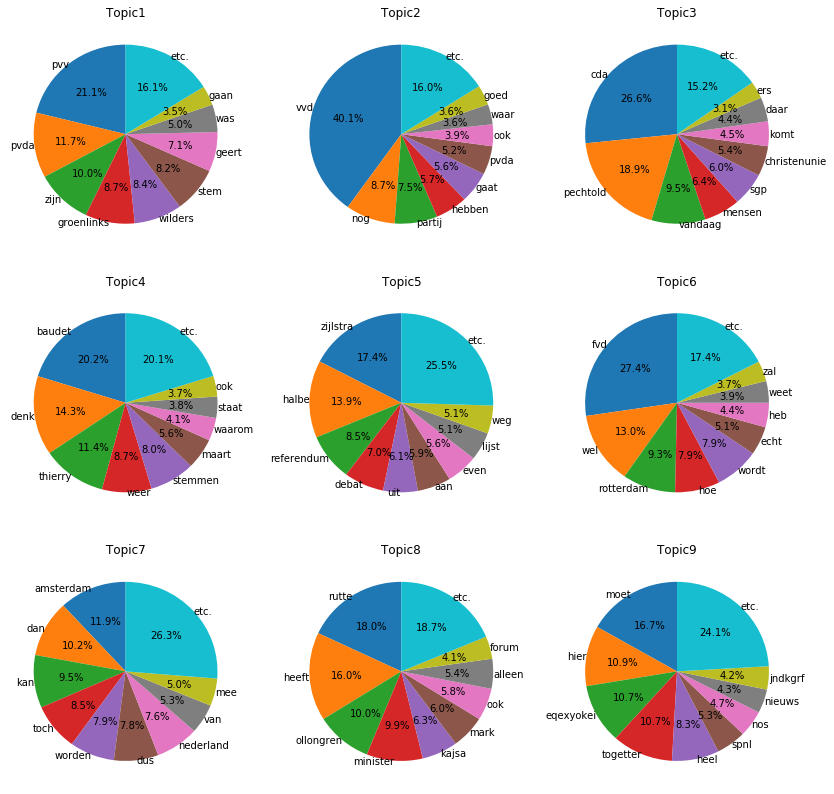

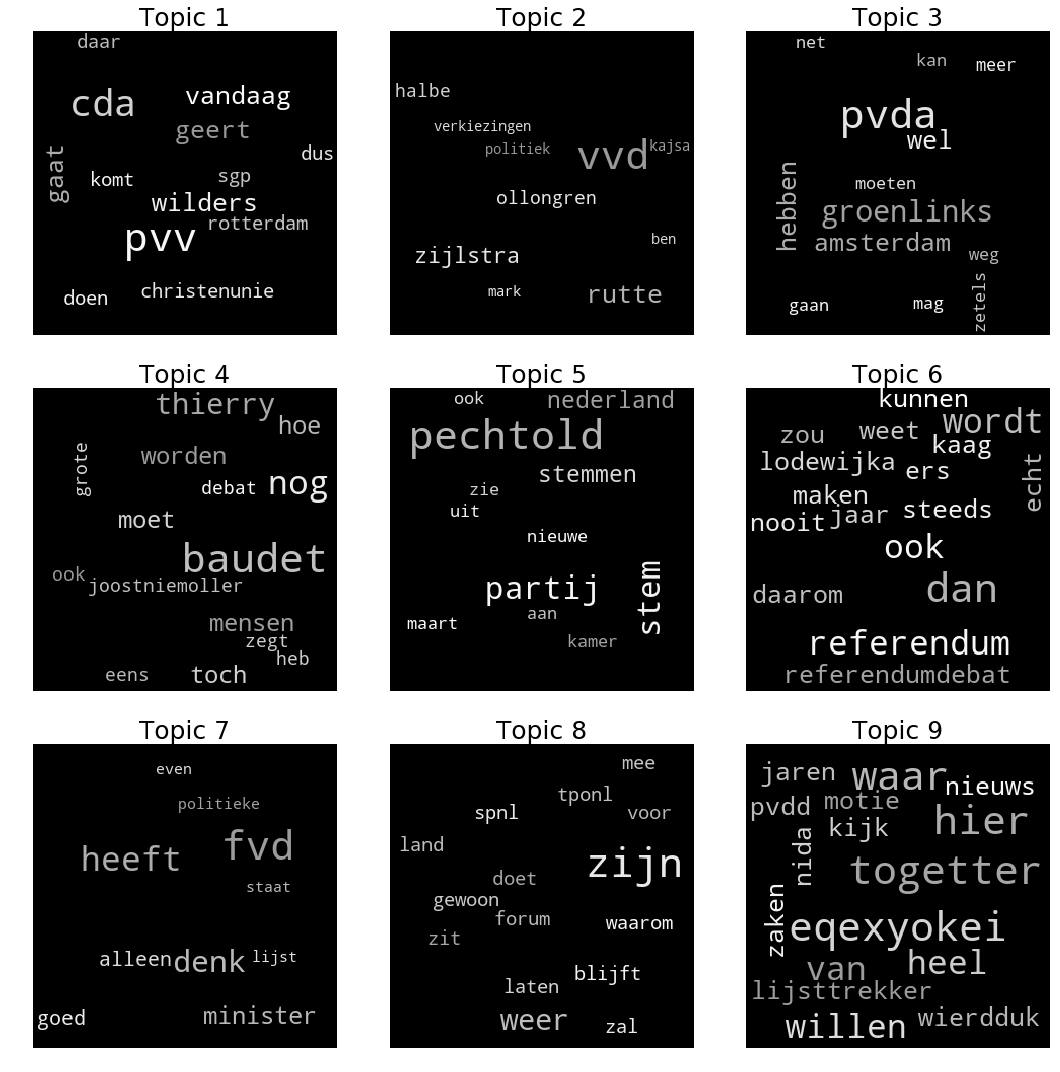

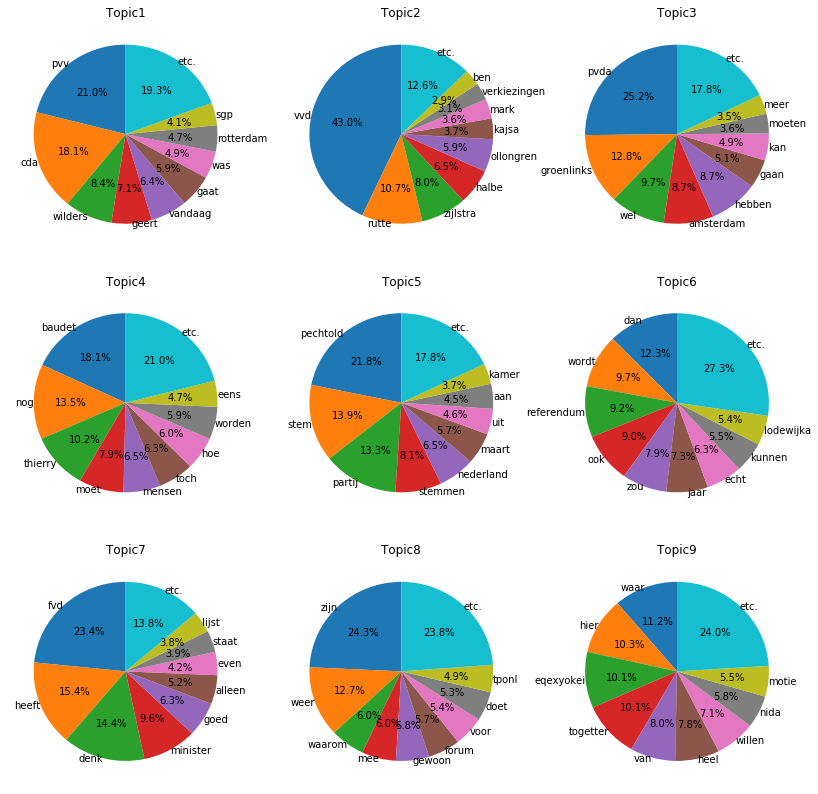

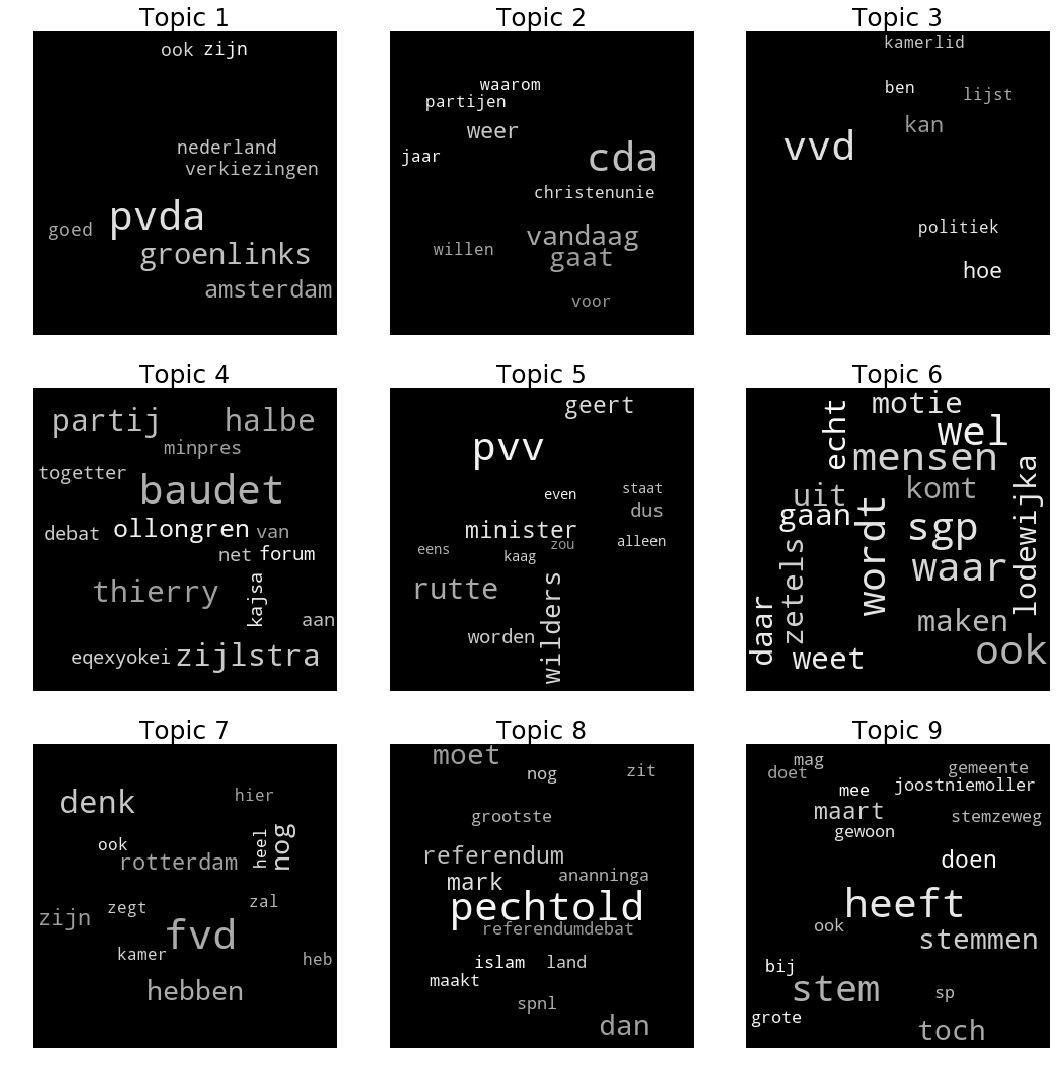

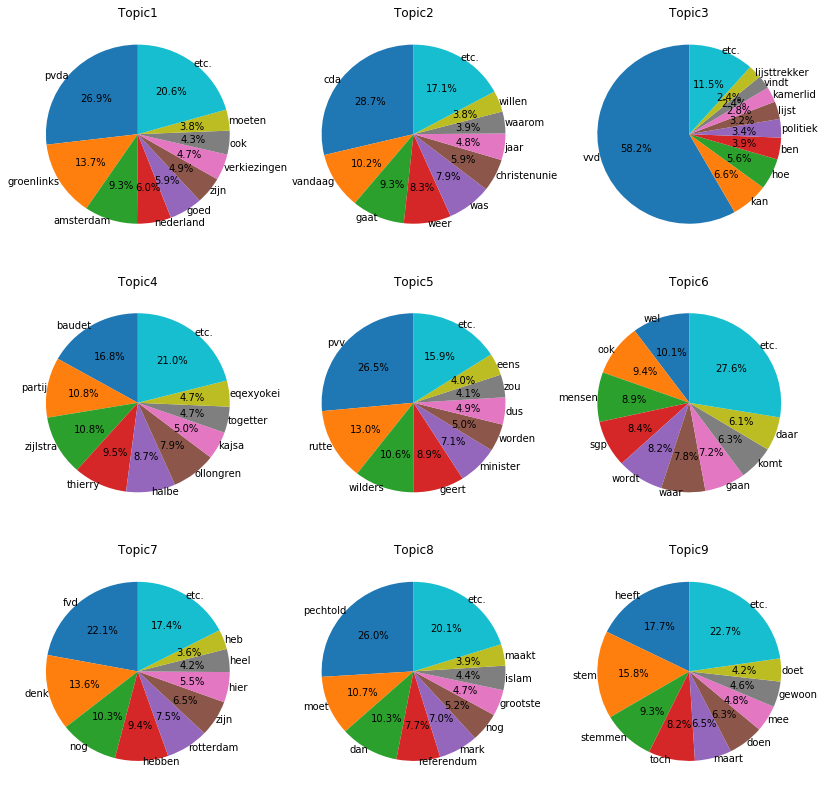

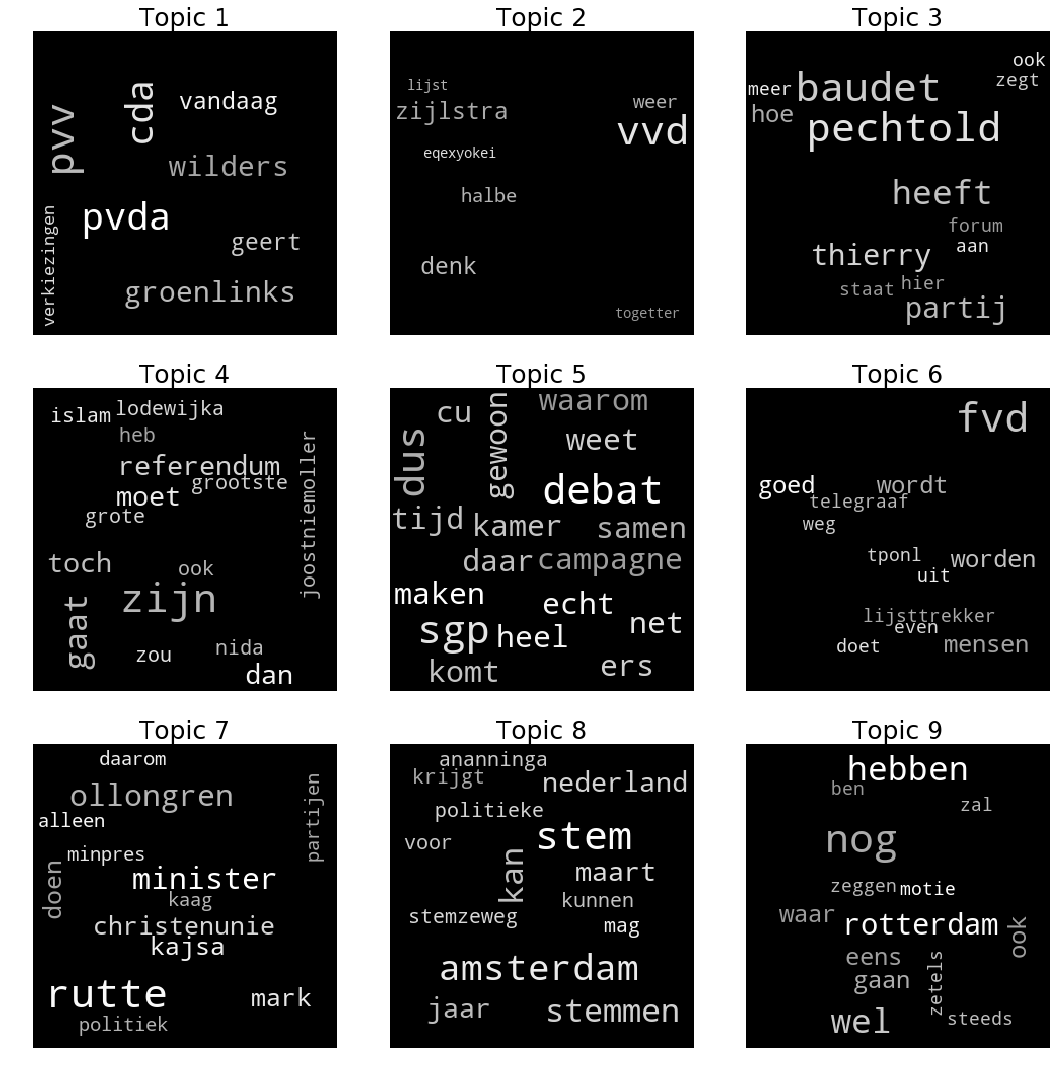

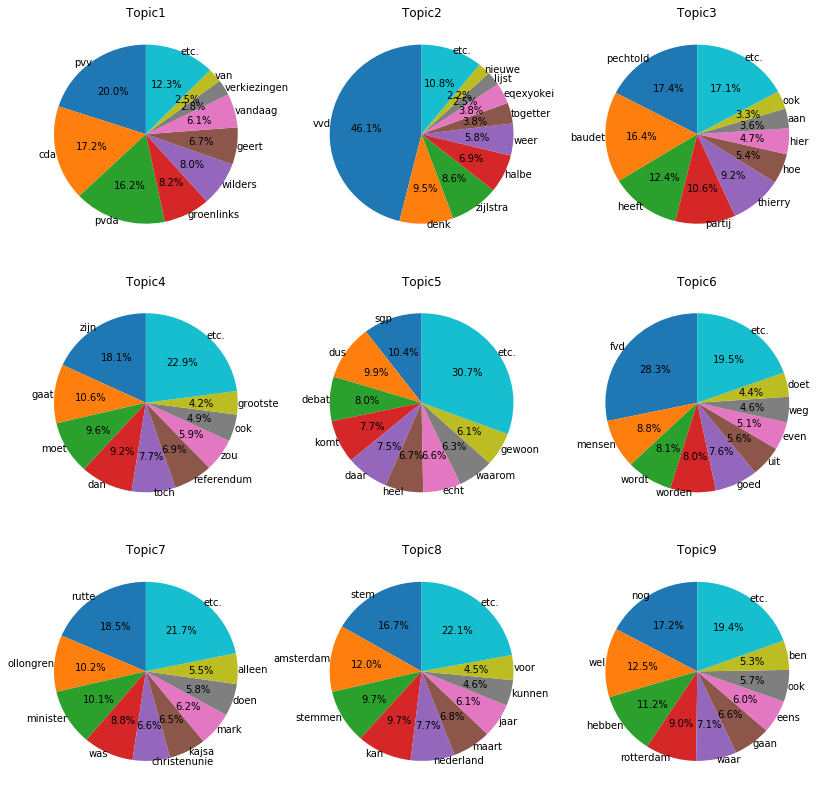

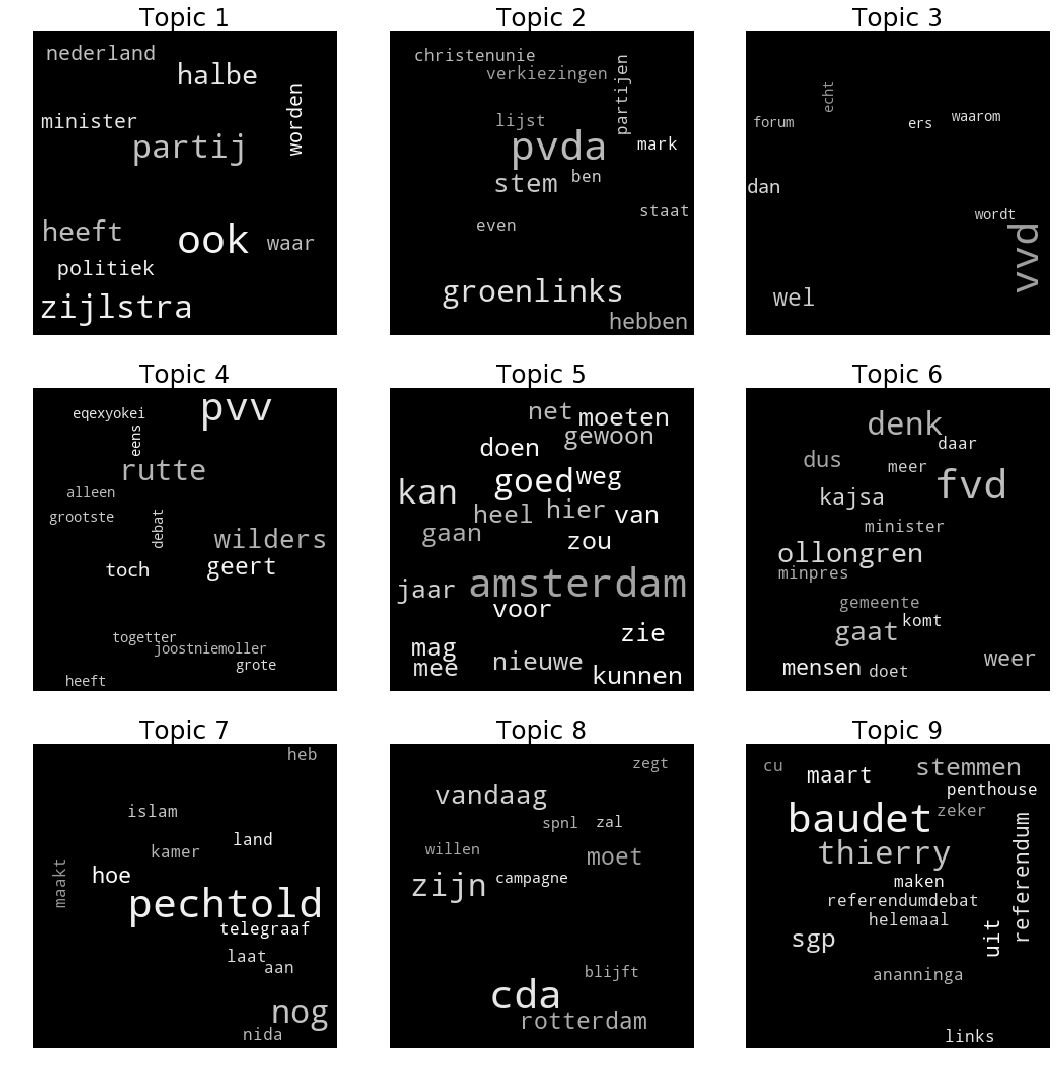

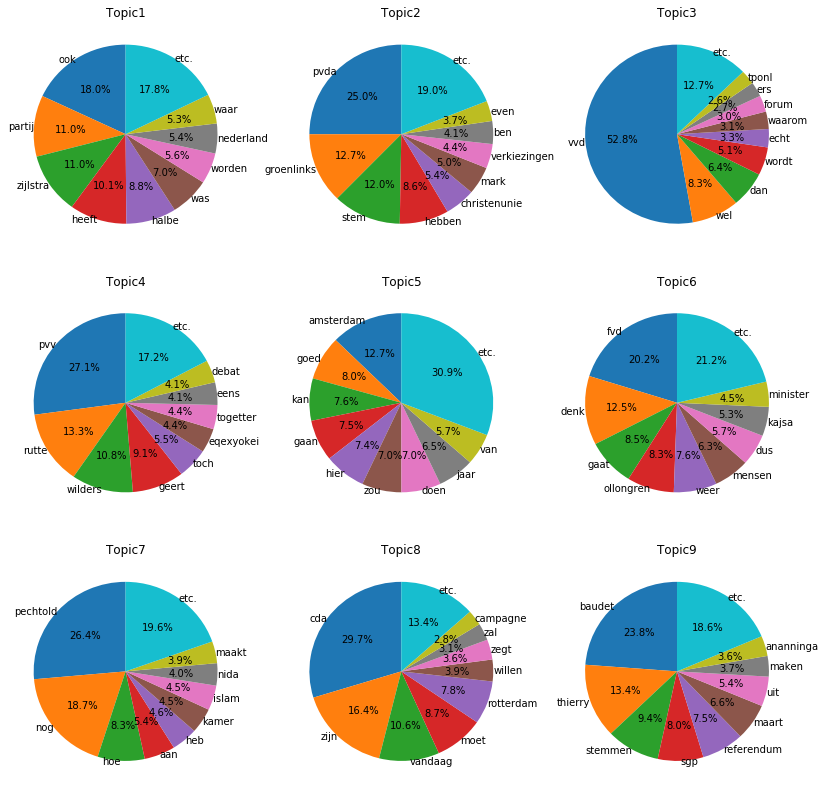

In [32]:
for i, s in enumerate(seed):
    lda_model = joblib.load(archive_path2+'lda_model_chkrobust_%s.sav'%s)
    lda_output = np.load(archive_path2+"lda_output_chkrobust_%s.npy"%s)
    lda_components = np.load(archive_path2+"lda_components_chkrobust_%s.npy"%s)
    order = pd.DataFrame(lda_output).sum().sort_values(ascending=False).index
    df_topic_words = pd.DataFrame(lda_components).loc[order]
    df_topic_words.index = topic_names
    df_topic_words.columns = word_list

    df_wordcloud = (df_topic_words.apply(lambda x: x/x.sum(), axis=1)*50).astype(int)
    plot_wordcloud(df_wordcloud, ncols=3, nrows=3)
    
    p = 40
    plt.figure(figsize=(14,14))
    for i,row in enumerate(df_topic_words.iterrows()):
        row = row[1]
        row = row.sort_values(ascending=False).head(15)
        show = row.values > np.percentile(row.values, p)
        non_show = row.values <= np.percentile(row.values, p)

        new_row_val = row.values[show].tolist()
        new_row_val.append(row.values[non_show].sum())

        new_row_index = row.index[show].tolist()
        new_row_index.append("etc.")

        plt.subplot(3,3,i+1)
        plt.pie(new_row_val, labels=new_row_index, startangle=90, labeldistance=1.0,
                autopct='%.1f%%')
        plt.title(row.name)